In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
TORQUE_OFFSET = 0.07
L = 0.13

In [3]:
def load_data(name, threshold=5):
    data = pd.read_csv(name)
    data.rename(columns={"# t": "t"}, inplace=True)
    data.torque += TORQUE_OFFSET
    data.torque = -data.torque
    data.insert(3, "force", data.torque / L)

    first_non_zero_i = None
    last_non_zero_i = None
    seq = 0
    found = True
    for i, (t, pulse, torque, _) in data.iterrows():
        if torque > 0.001:
            if first_non_zero_i is None:
                first_non_zero_i = i
            last_non_zero_i = i
        if np.isnan(pulse) or np.isnan(torque) or np.isclose(t, 0):
            seq += 1
        else:
            seq = 0
        if seq >= threshold:
            print("found", i)
            break
    else:
        found = False

    if found:
        data = data[first_non_zero_i:min(last_non_zero_i, i-seq+1)]

    data.t -= data.t.min()

    return data

In [4]:
from pathlib import Path

In [5]:
dir_path = Path('.').parent / 'data'
datasets = dir_path.glob("./*.csv")
dfs = [load_data(dataset) for dataset in datasets]

found 5508
found 5512
found 5505
found 5584
found 5531
found 5552
found 5531
found 5420
found 5627
found 5522


In [6]:
import itertools

<Figure size 640x480 with 0 Axes>

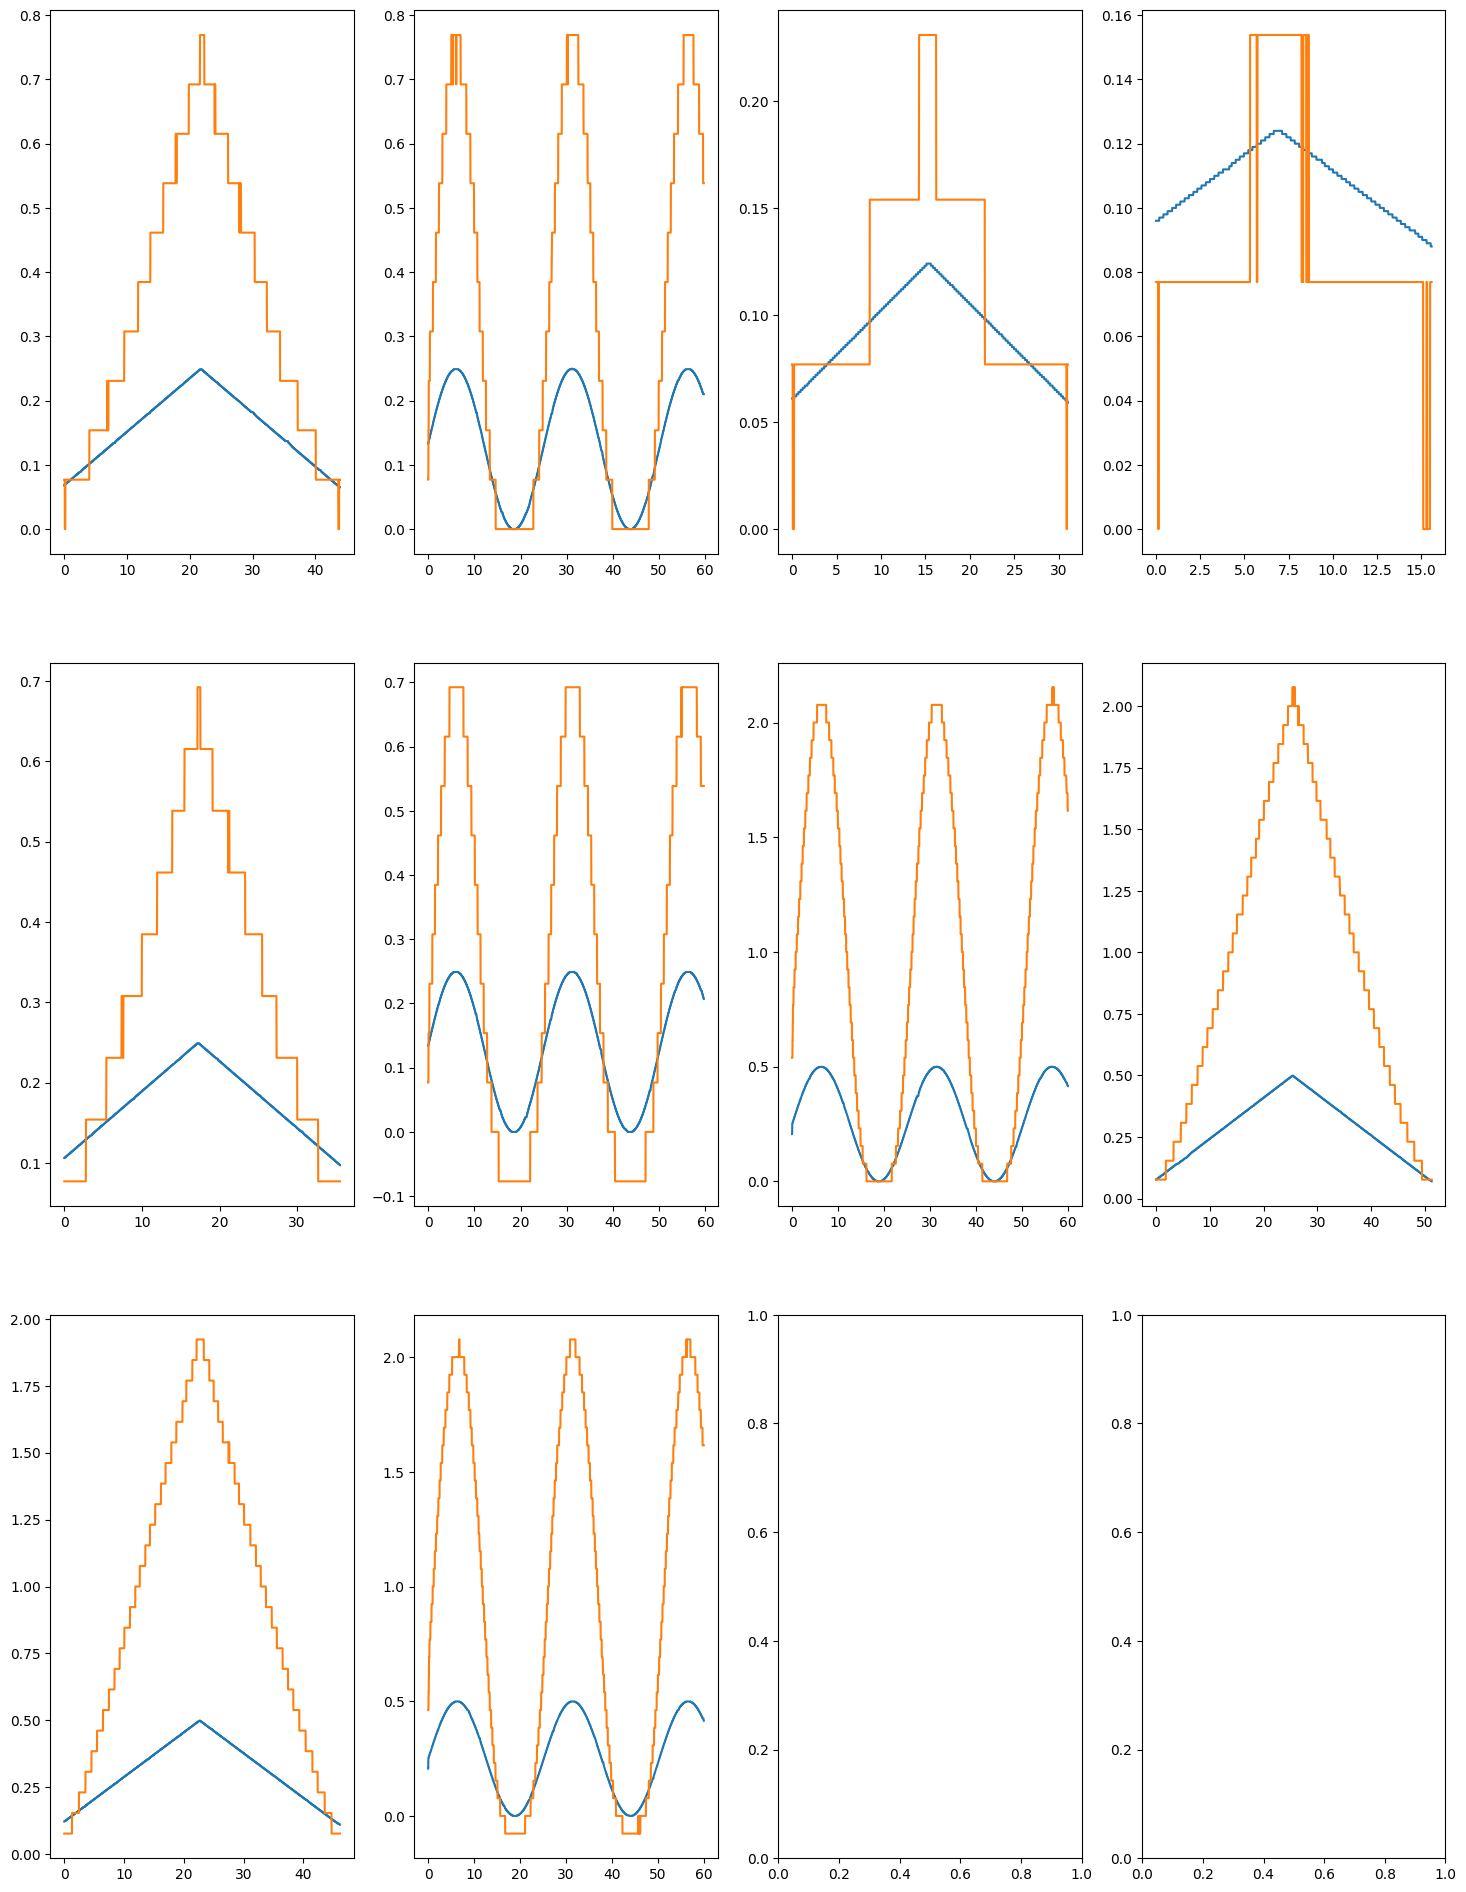

In [7]:
fig = plt.figure()
rows = int(np.ceil(len(dfs) / 3))
fig, axs_2d = plt.subplots(3, rows, figsize=(18, 6 * rows))
axes = list(itertools.chain(*axs_2d))

for ax, df in zip(axes, dfs):
    ax.plot(df.t, df.pulse)
    ax.plot(df.t, df.force)

plt.show()

In [8]:
from scipy.optimize import curve_fit

In [9]:
def linear(x, a, b):
    return a * x + b

def pow_f(x, a, b, c):
    return a * np.power(x, b) + c

def poly_2(x, a, b, c):
    return a * np.power(x, 2) + b * x + c


all_funcs = [linear, pow_f, poly_2]

In [10]:
all_data = pd.concat(dfs)

In [11]:
def fit_data(dt=all_data, cutoff=None, funcs=all_funcs):
    fig = plt.figure()
    fig, axs_2d = plt.subplots(3, rows, figsize=(18, 6 * rows))
    axes = list(itertools.chain(*axs_2d))

    if cutoff is not None:
        dt = dt[all_data.force < cutoff]

    popts = []
    pcovs = []
    for func in funcs:
        popt, pcov = curve_fit(func, dt.pulse, dt.force)
        popts.append(popt)
        pcovs.append(pcov)

    for ax, df in zip(axes, dfs):
        if cutoff is not None:
            df = df[df.force < cutoff]
        ax.scatter(df.pulse, df.force, s=0.1)

        for popt, func in zip(popts, funcs):
            ax.plot(df.pulse, func(df.pulse, *popt), label=f"{func.__name__}: {[f'{v:.2f}' for v in popt]}")

        ax.legend()

    plt.show()

    return popts, pcovs

<Figure size 640x480 with 0 Axes>

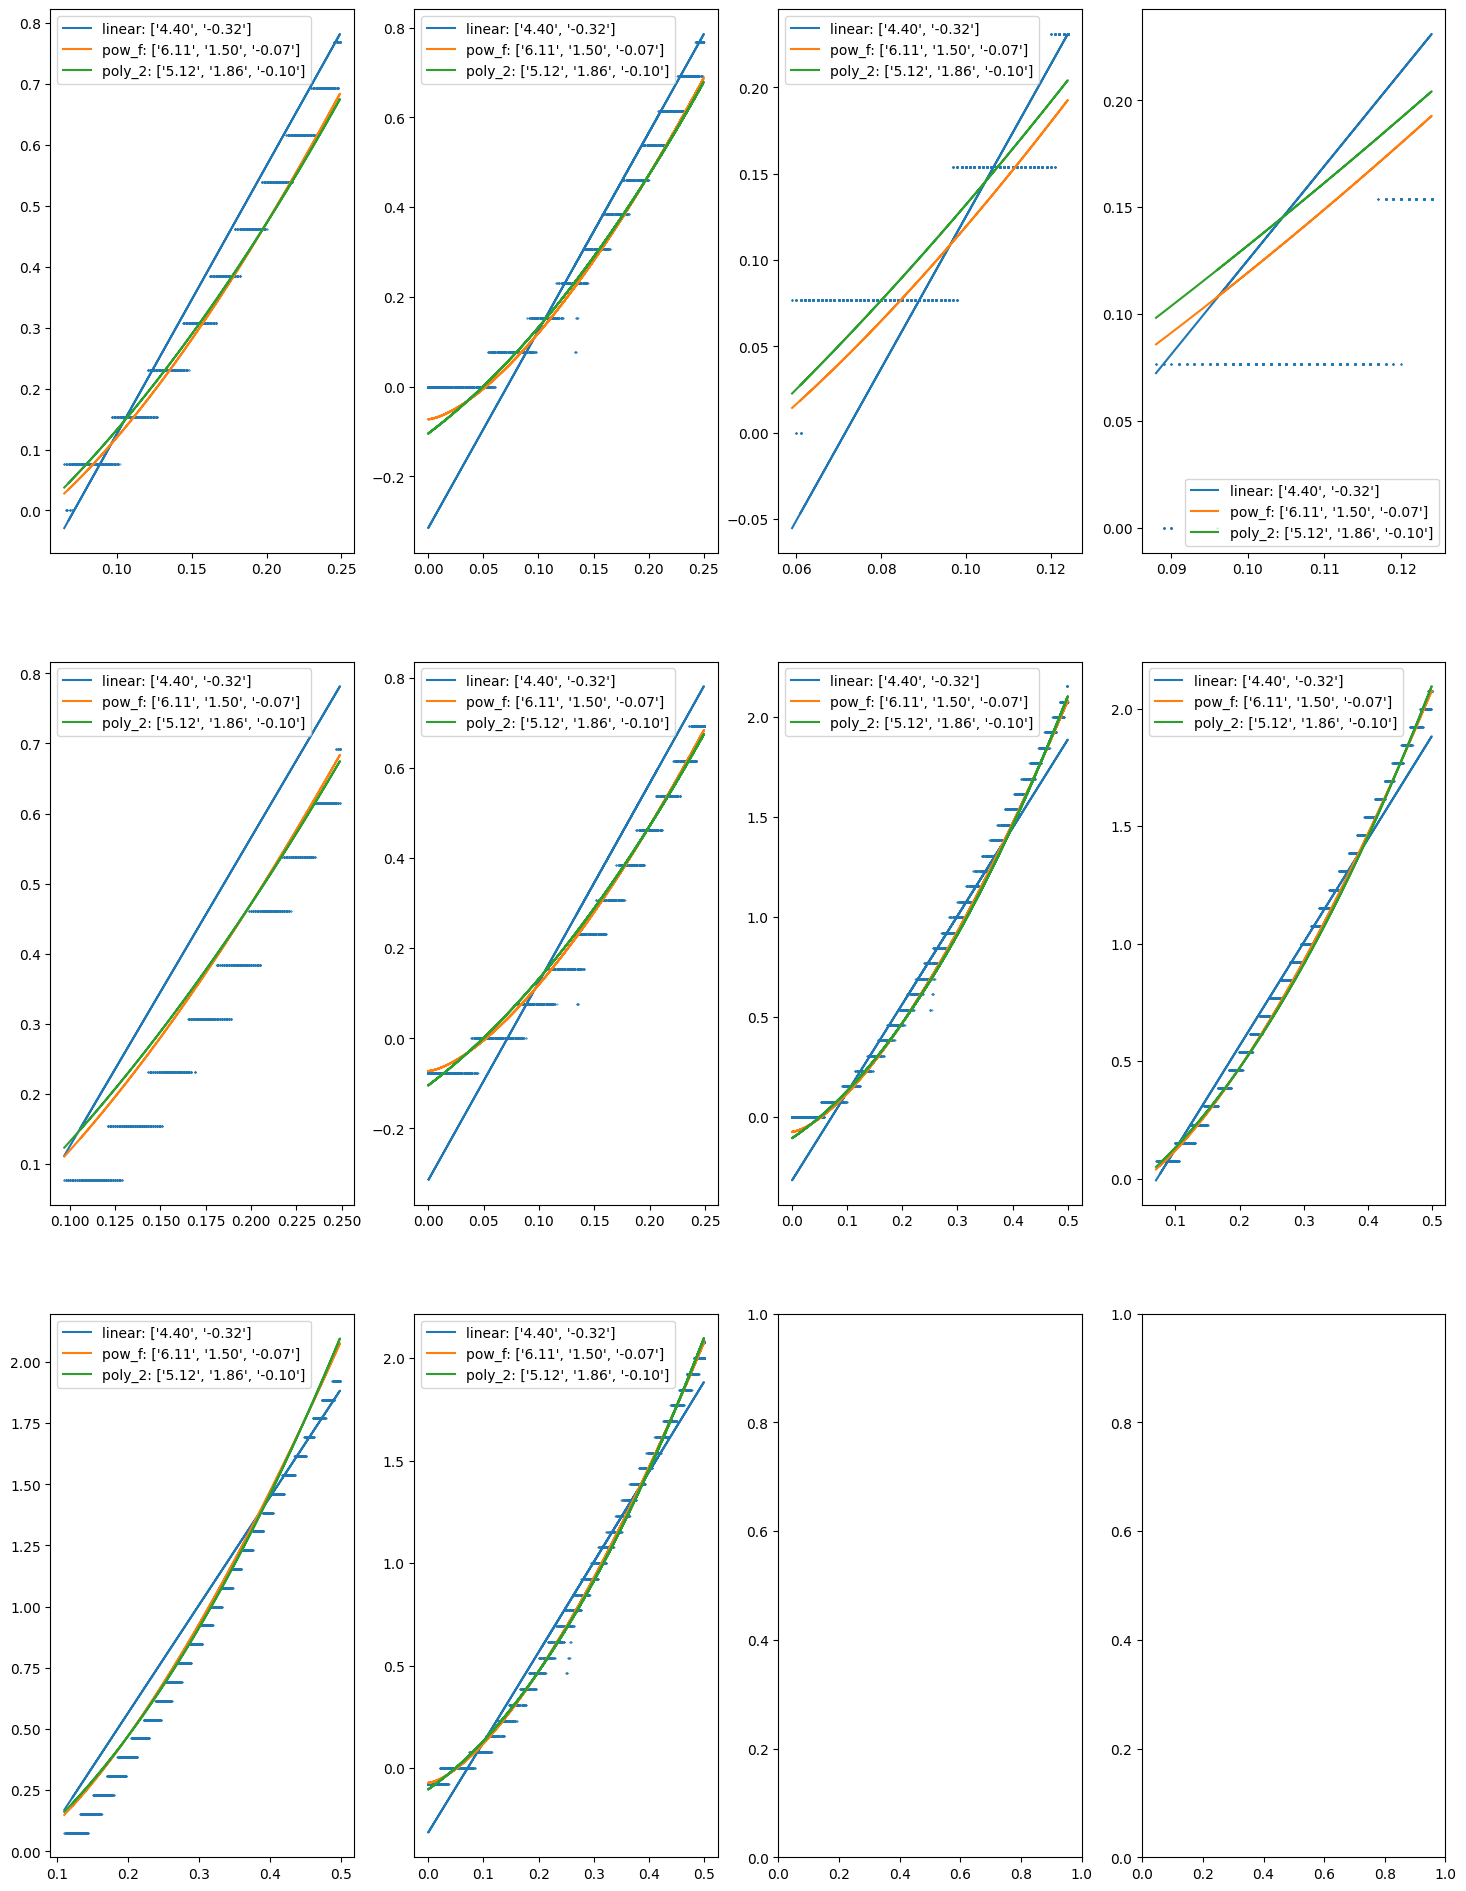

In [12]:
all_popts, all_pcovs = fit_data(all_data)

<Figure size 640x480 with 0 Axes>

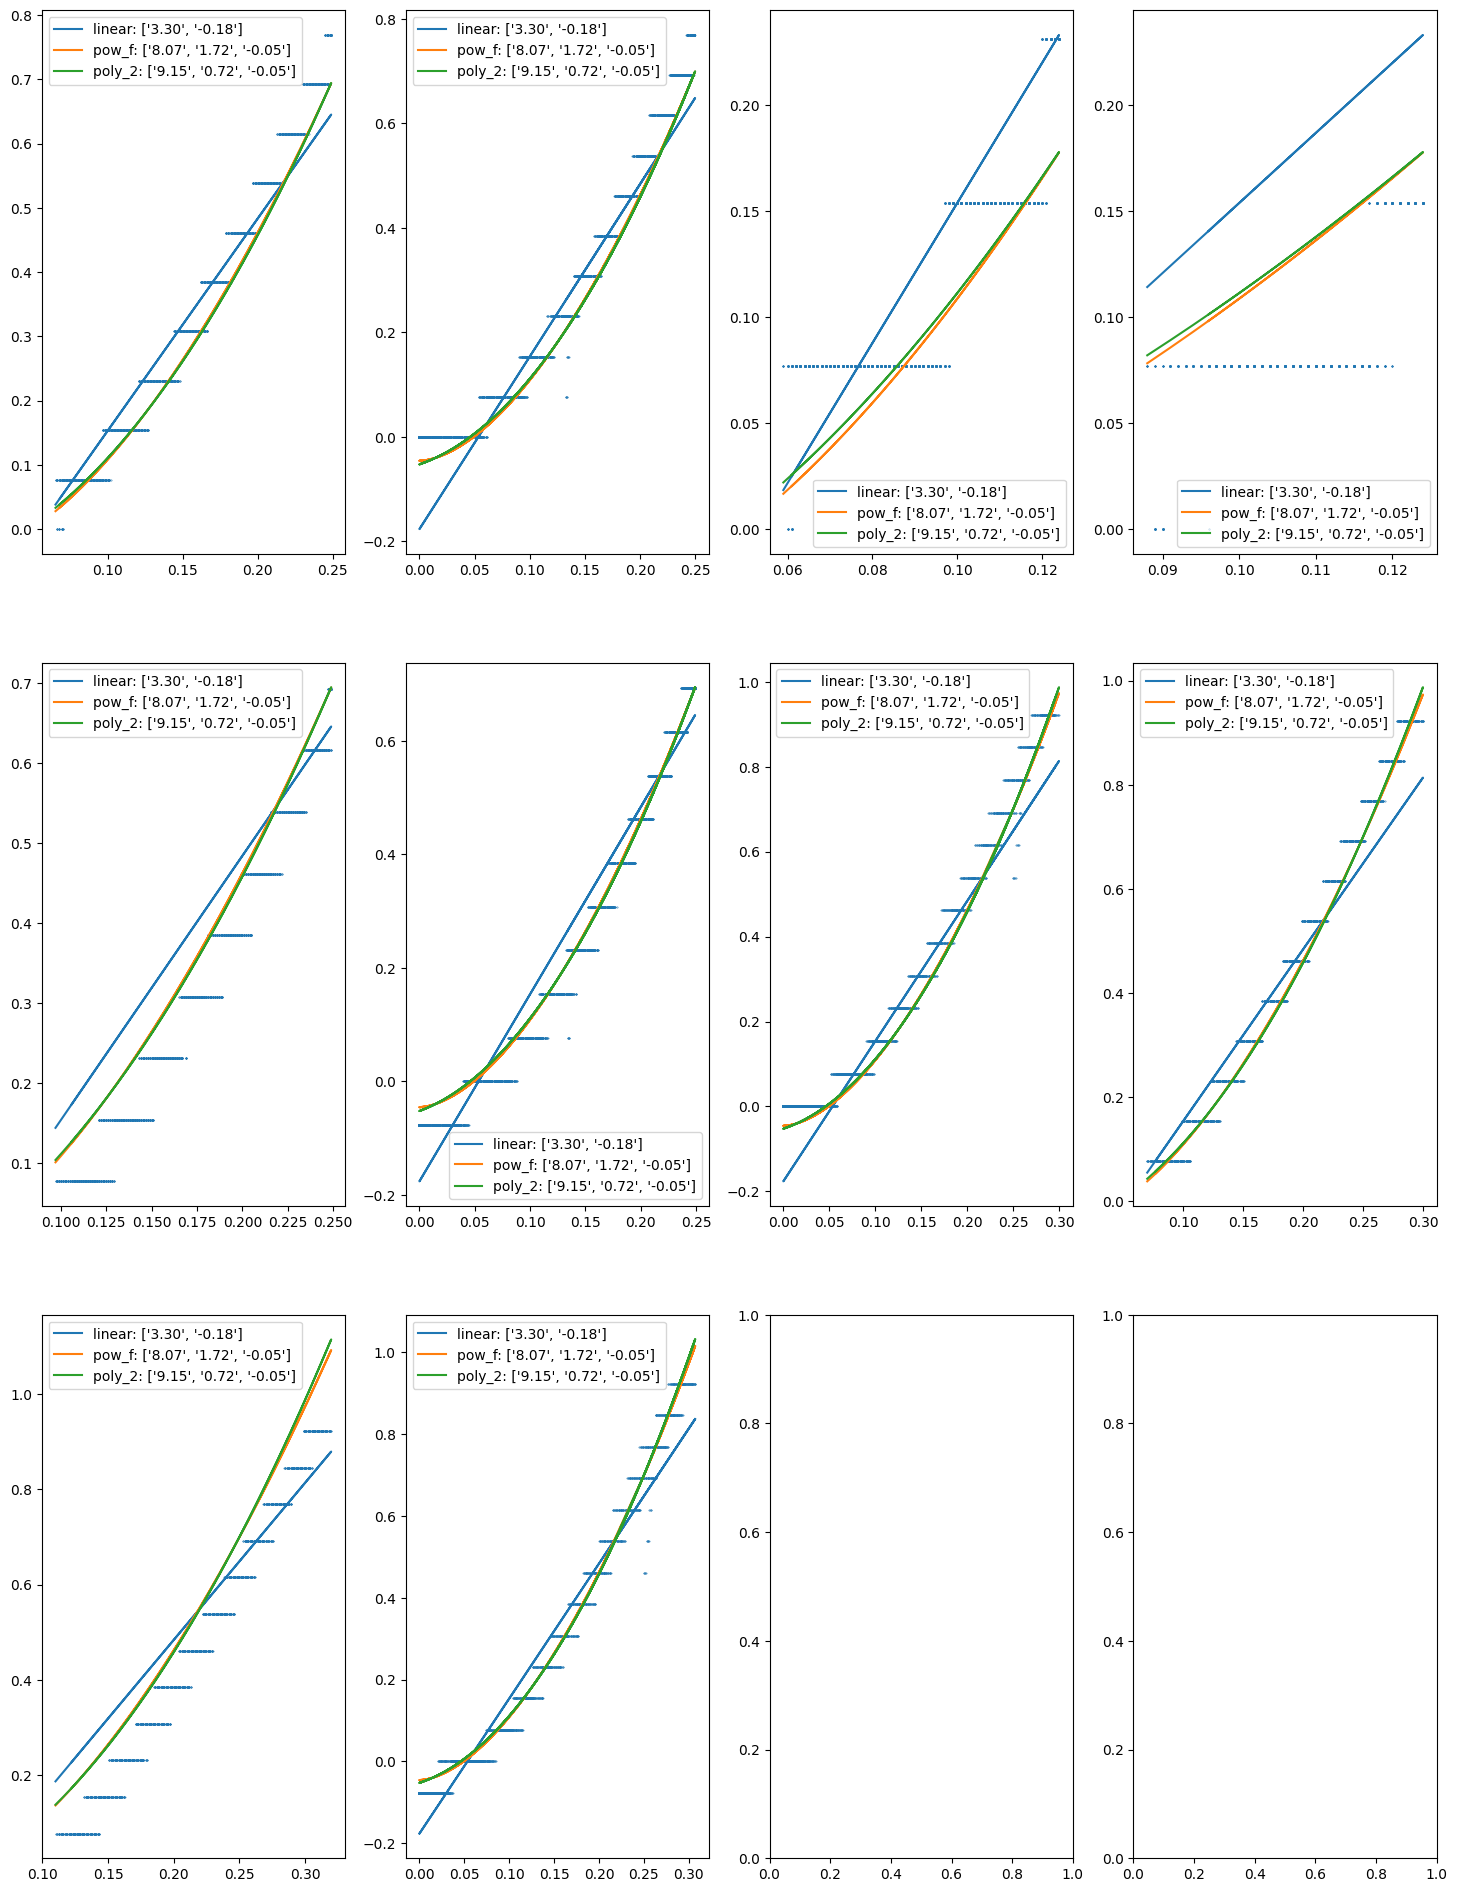

In [13]:
mid_popts, mid_pcovs = fit_data(cutoff=1)

<Figure size 640x480 with 0 Axes>

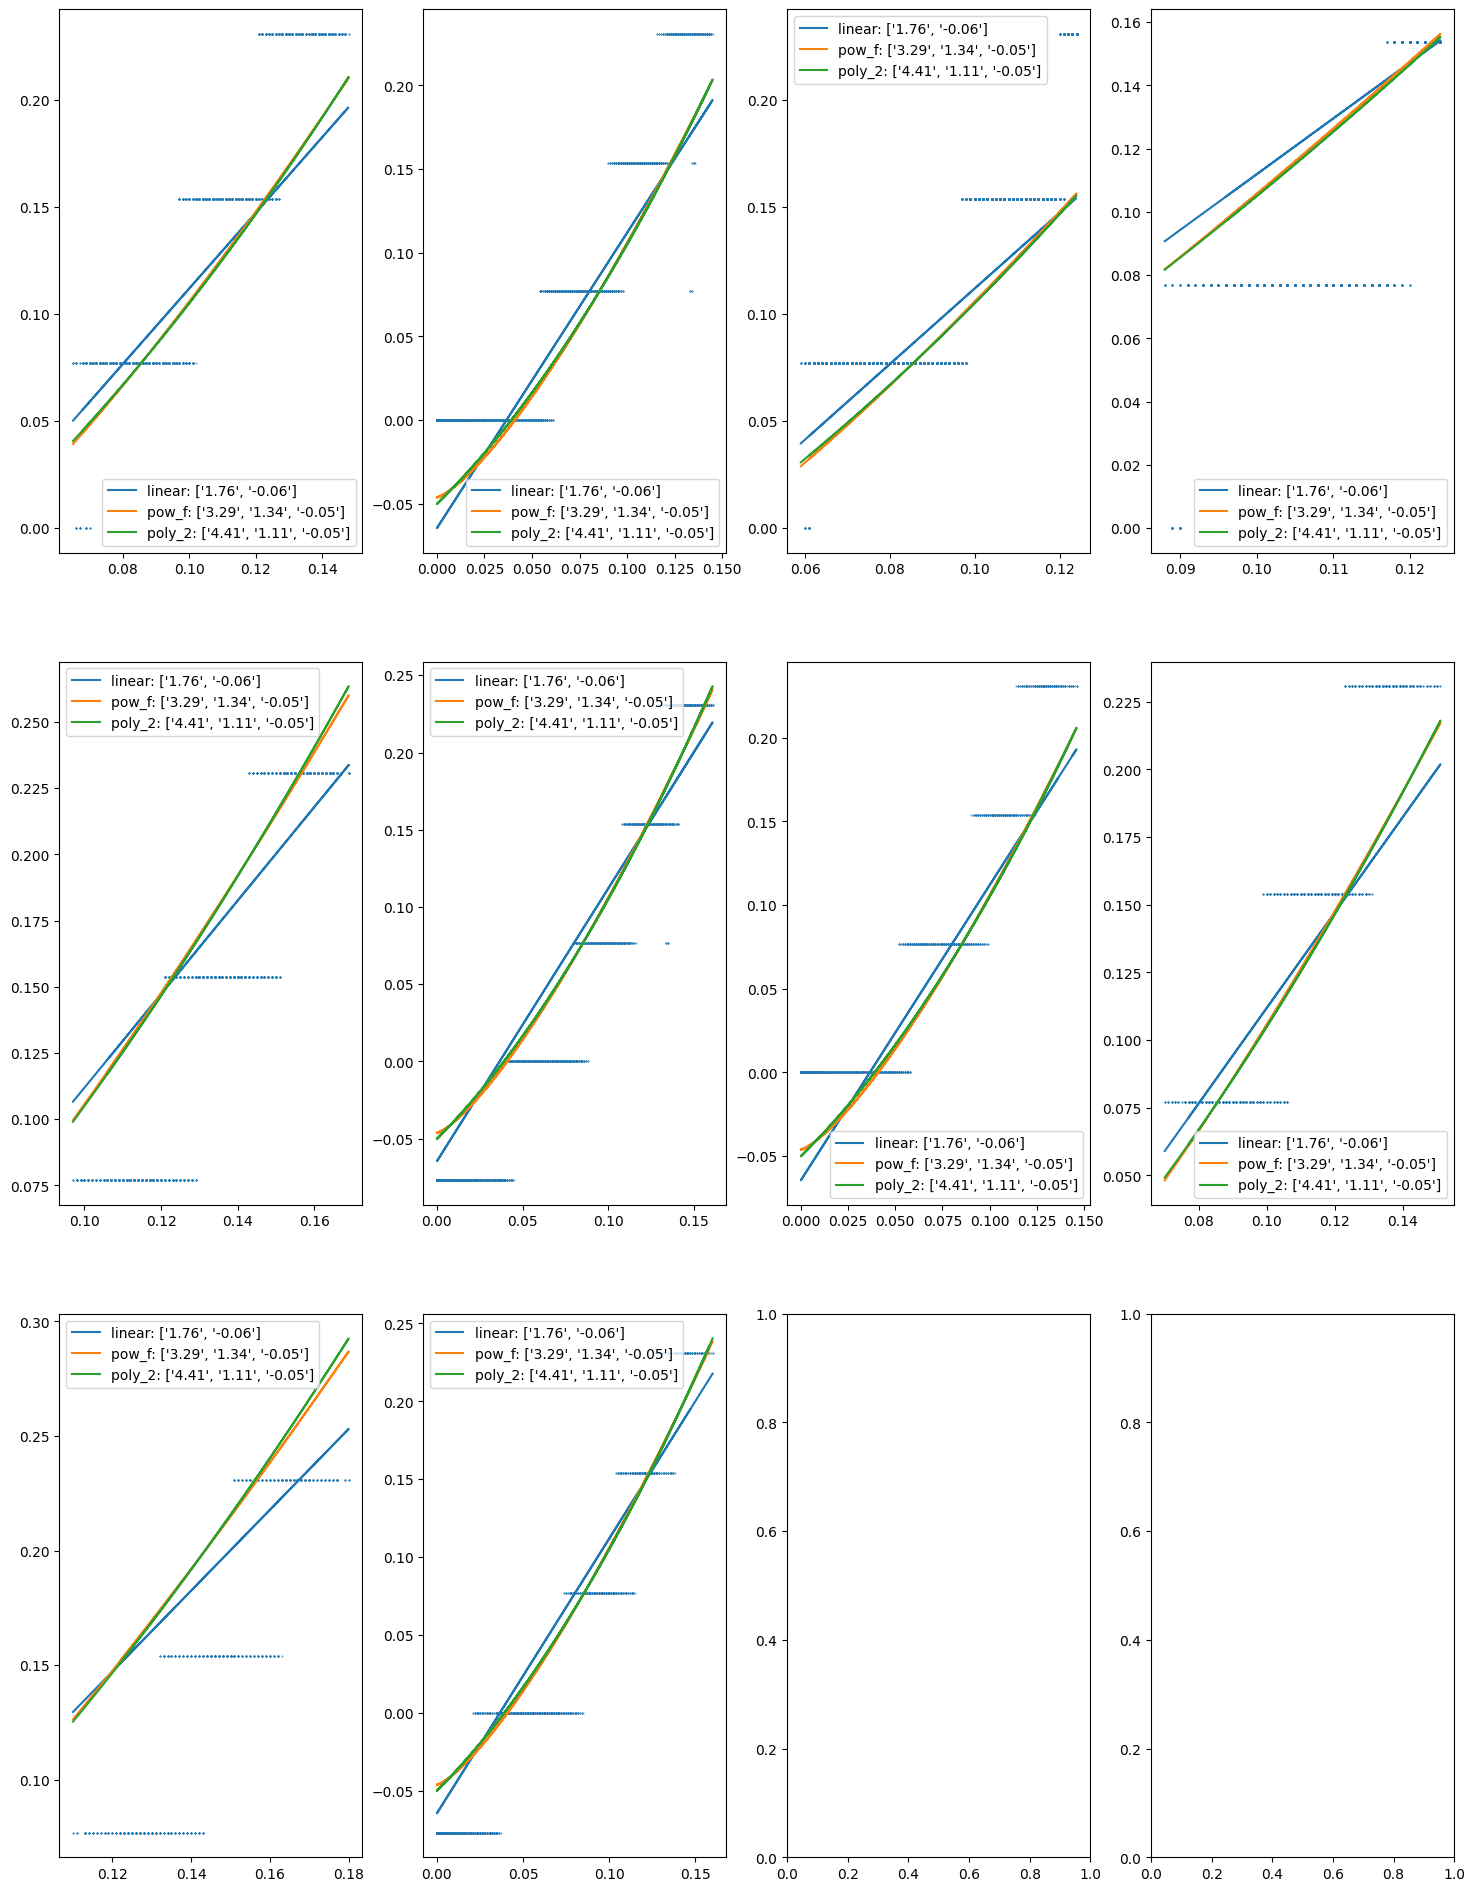

In [14]:
small_popts, small_pcovs = fit_data(cutoff=0.3)

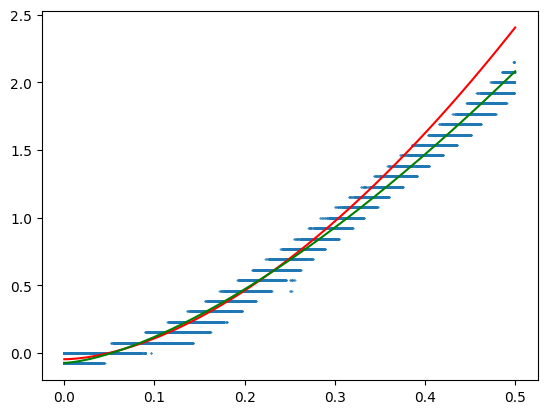

In [15]:
all_pulse = sorted(all_data.pulse)
plt.scatter(all_data.pulse, all_data.force, s=0.1)
plt.plot(all_pulse, pow_f(all_pulse, *mid_popts[1]), 'r-', label="mid")
plt.plot(all_pulse, pow_f(all_pulse, *all_popts[1]), 'g-', label="all")

In [16]:
approx_f = pow_f
approx_params = mid_popts[1]
a, b, c = approx_params
a, b, c

(8.072144085973537, 1.718983235884459, -0.045601557637296466)

In [23]:
# Transferable format
a, b, c = np.asarray([8.072144085973537, 1.718983235884459, -0.045601557637296466], dtype=np.float32)
def get_pulse(force):
    return np.power( (force - c) / a , 1/b)

/tmp/ipykernel_2519/3106757978.py:3: RuntimeWarning: invalid value encountered in power
  return np.power( (force - c) / a , 1/b)


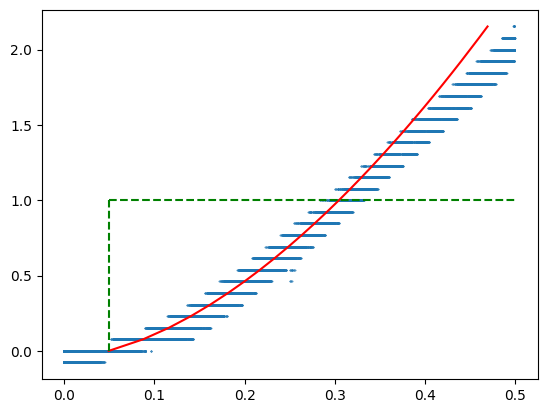

In [24]:
all_force = sorted(all_data.force)
plt.scatter(all_data.pulse, all_data.force, s=0.1)
plt.plot(get_pulse(all_force), all_force, 'r-', label="mid")

zero_force_pulse = get_pulse(0)
plt.vlines(zero_force_pulse, 0, 1, 'g', '--')
plt.hlines(1, zero_force_pulse, 0.5, 'g', '--')